# Travaux pratiques : séance 4

## Opérateurs connexes : travail évalué

Dans ce TP nous allons travailler sur les opérateurs connexes.

Ce rapport contient un ensemble de jeux d'essais permettant d'évaluer qualitativement la justesse de mon implémentation.
Chaque exercice donne lieu à un texte qui explique la démarche employée et justifie mes choix d'implémentation.

Pour les jeux de tests, nous considérons des images suffisamment variées et représentatives (images binaires, images en niveaux de gris, images naturelles, etc.).

## Extrema régionaux

1.  Implémenter en Python deux fonctions permettant de calculer les maxima régionaux et les minima régionaux d'une image. Vous pourrez vous appuyer sur le pseudo-code ci-dessous :
```
Algorithme : calcul des maxima régionaux
Entrée : image f
Sortie : image binaire M contenant les maxima régionaux de f (M[p]=255 si et seulement si p appartient à un maximum régional)

Pour tous les points p de M faire :
    M[p]=255  // au départ tous les points sont "candidats"

Pour tous les points p de f faire :
    Si M[p] est candidat et qu'il existe un point voisin q ayant une valeur plus élevée que p dans f :
        // alors le point p n'est pas un maxima (comme il a un voisin ayant une valeur plus élevée)
        M[p]=0
        // et tous les points voisins de p de valeur inférieure ne sont pas non plus des maxima : 
        // on lance une propagation à partir de p pour supprimer de proche en proche tous les points ayant une valeur inférieure à p
        fifo.push(p)
        Tant que la file fifo n'est pas vide :
            p=fifo.pop()
            Pour tous les voisins q de p :
                si q a une valeur inférieure à p dans f et que q est candidat :
                    M[q]=0
                    fifo.push(q)
```

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
    
def maxima_regionaux(img):
    M = np.full_like(img, 255, dtype=np.uint8)
    fifo = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            voisins = img[max(i-1,0):min(i+2,img.shape[0]),max(0,j-1):min(j+2,img.shape[1])]
            if M[i,j] == 255 and np.max(voisins) > img[i,j]:
                M[i,j] = 0
                fifo.append([i,j])
                while fifo:
                    x,y = fifo.pop()
                    voisins = img[max(x-1,0):min(x+2,img.shape[0]),max(0,y-1):min(y+2,img.shape[1])]
                    for a in range(voisins.shape[0]):
                        for b in range(voisins.shape[1]):
                            if M[x+a-1,y+b-1] == 255 and voisins[a,b] <= img[x,y]:
                                M[x+a-1,y+b-1] = 0
                                fifo.append([x+a-1,y+b-1])
    return M

def minima_regionaux(img):
    return maxima_regionaux(skimage.util.invert(img))

2. Comparer votre implémentation avec l'implémentation proposée dans `scikit-image` : https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.local_maxima

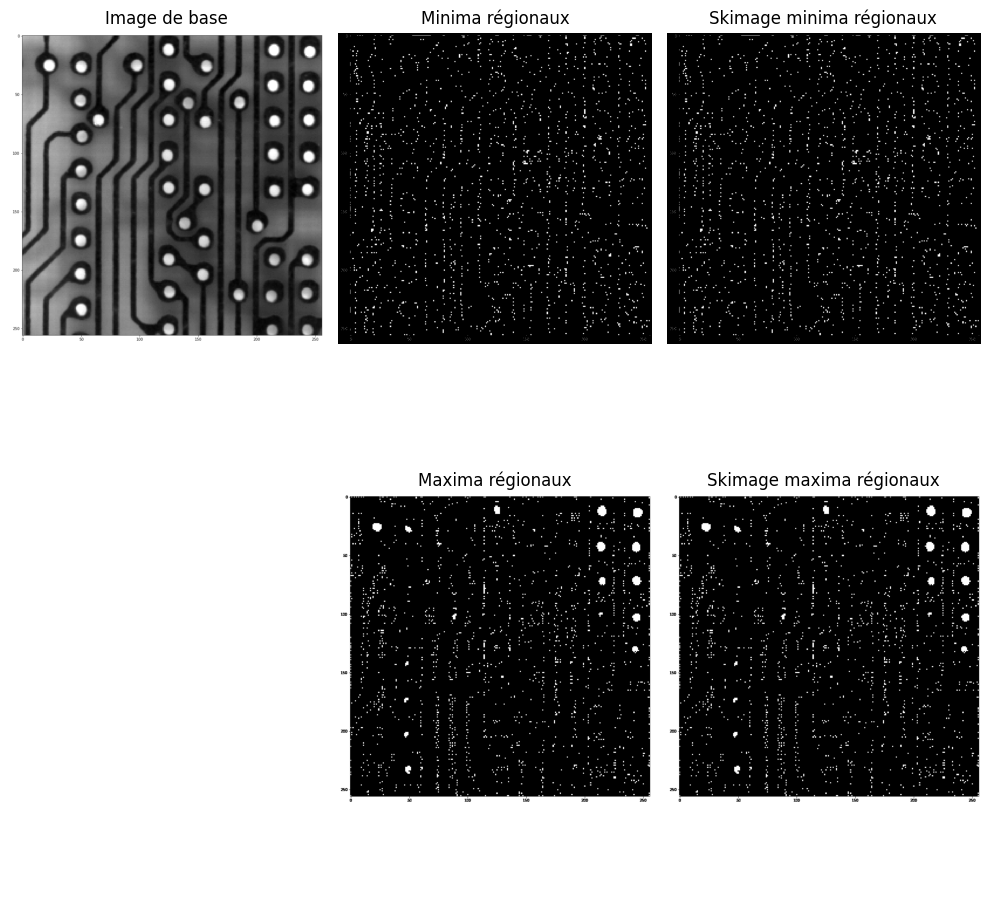

In [58]:
img = skimage.io.imread('pcb_gray.png', as_gray=True)
img = skimage.img_as_ubyte(img)
fig,ax = plt.subplots(2, 3, figsize=(10, 10))
minima = minima_regionaux(img)
maxima = maxima_regionaux(img)
skimage_minima = skimage.morphology.extrema.local_minima(img, connectivity=2)
skimage_maxima = skimage.morphology.extrema.local_maxima(img, connectivity=2)
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('Image de base')

ax[0, 1].imshow(minima, cmap='gray')
ax[0, 1].set_title('Minima régionaux')
ax[0, 2].imshow(skimage_minima, cmap='gray')
ax[0, 2].set_title('Skimage minima régionaux')

ax[1, 1].imshow(maxima, cmap='gray')
ax[1, 1].set_title('Maxima régionaux')
ax[1, 2].imshow(skimage_maxima, cmap='gray')
ax[1, 2].set_title('Skimage maxima régionaux')
for cell in np.ndindex(ax.shape):
    ax[cell].axis('off')
fig.tight_layout()
plt.show()

## Reconstruction géodésique

1. Implémenter en Python l'opérateur de reconstruction géodésique.
Vous pourrez vous appuyer sur l'algorithme décrit dans cet article :
https://people.cmm.minesparis.psl.eu/users/marcoteg/cv/publi_pdf/MM_refs/Vincent/Vincent_Reconstruction_10.1.1.116.5241.pdf

In [17]:

def N_g_plus(J,p):
    i,j = p
    return np.append( J[ i:i+1 , max(j-1,0):j+1 ].flatten(), J[ max(i-1,0):i , max(j-1,0):min(j+2,J.shape[1])].flatten())

def N_g_moins(J,p):
    i,j = p
    return np.append(J[i:i+1,j:min(j+2,J.shape[1])].flatten(),J[i+1:min(i+2,J.shape[0]),max(j-1,0):min(j+2,J.shape[1])].flatten())

def reconstruction_geodesique(J,mask):
    marker = J.copy()
    fifo = []
    for p in np.ndindex(marker.shape):                      # raster order
        voisinsPlus = N_g_plus(marker,p)
        marker[p] = min((np.max(voisinsPlus)),mask[p])

    for p1 in reversed(range(marker.shape[0])):             # reverse raster order (2 boucles car reverse ne marche pas sur les tuples)
        for p2 in reversed(range(marker.shape[1])):
            p = (p1,p2)
            voisinsMoins = N_g_moins(marker,p)
            marker[p] = min((np.max(voisinsMoins)),mask[p])
            for index in range(len(voisinsMoins[1:5])):
                n = index+6 if p[1] == marker.shape[1]-1 else index+5
                i = int( (n-n%3) / 3)
                j = n%3
                if marker[p1+i-1,p2+j-1] < marker[p] and marker[p1+i-1,p2+j-1] < mask[p1+i-1,p2+j-1]:
                    fifo.append(p)
                    break
    while fifo:
        p= fifo.pop()
        voisins = marker[max(p[0]-1,0):min(p[0]+2,marker.shape[0]),max(0,p[1]-1):min(p[1]+2,marker.shape[1])]
        for q in np.ndindex(voisins.shape):
            if marker[q] < marker[p] and mask[q] != mask[p]:
                marker[q] = min(marker[p],mask[q])
                fifo.append(q)
    return marker

2. Comparer votre implémentation avec l'implémentation proposée dans `scikit-image` : https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.reconstruction

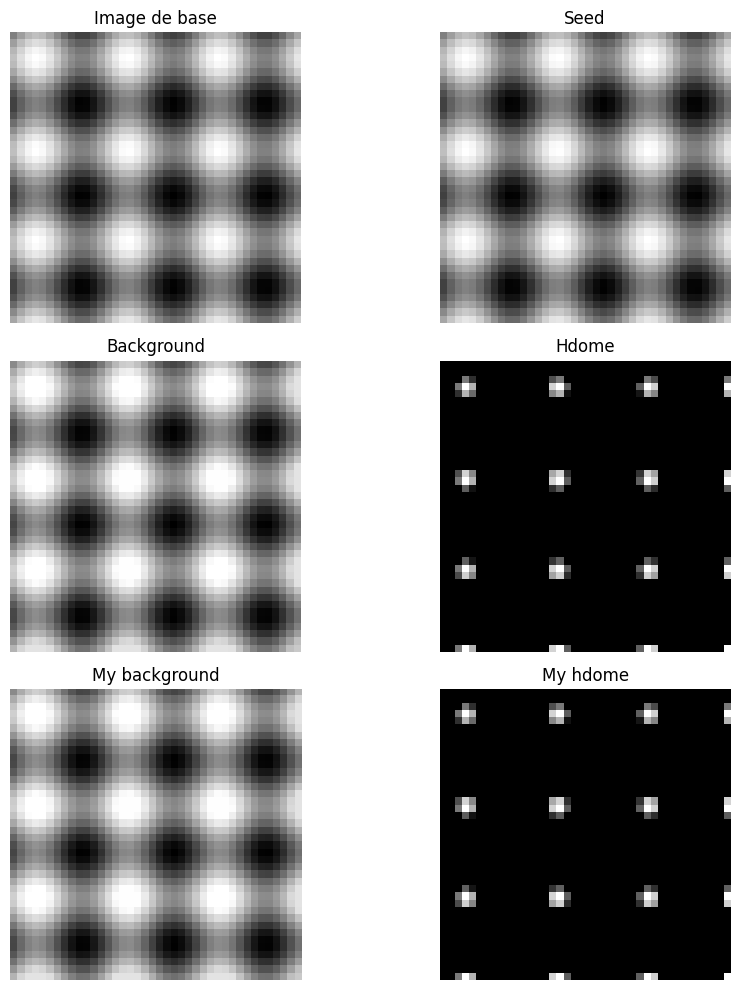

In [18]:
y, x = np.mgrid[:20:0.5, :20:0.5]
bumps = np.sin(x) + np.sin(y)
h = 0.3
seed = bumps - h
background = skimage.morphology.reconstruction(seed, bumps)
hdome = bumps - background
my_background = reconstruction_geodesique(seed, bumps)
my_hdome = bumps - my_background
fig,ax = plt.subplots(3, 2, figsize=(10, 10))
ax[0, 0].imshow(bumps, cmap='gray')
ax[0, 0].set_title('Image de base')
ax[0, 1].imshow(seed, cmap='gray')
ax[0, 1].set_title('Seed')
ax[1, 0].imshow(background, cmap='gray')
ax[1, 0].set_title('Background')
ax[1, 1].imshow(hdome, cmap='gray')
ax[1, 1].set_title('Hdome')
ax[2, 0].imshow(my_background, cmap='gray')
ax[2, 0].set_title('My background')
ax[2, 1].imshow(my_hdome, cmap='gray')
ax[2, 1].set_title('My hdome')
for cell in np.ndindex(ax.shape):
    ax[cell].axis('off')
fig.tight_layout()
plt.show()

## Filtrage par dynamique

Implémenter en Python deux fonctions `hmin_filter` (respectivement `hmax_filter`) permettant de supprimer les minima régionaux (respectivement maxima régionaux) dont la dynamique est inférieure à $h$ (respectivement supérieure à $h$).

In [59]:
def hmin_filter(img, h):
    return skimage.morphology.reconstruction(img + h, img, "erosion")

def hmax_filter(img,h):
    return skimage.morphology.reconstruction(img - h, img, "dilation")

## Extrema étendus

1. Implémenter en Python deux fonctions `hminima` (respectivement `hmaxima`) permettant de conserver uniquement les minima (respectivement maxima) ayant une dynamique supérieure à un seuil $h$.

In [60]:
def hminima(img,depth):
    return ((hmin_filter(img,depth)-img) >= depth)

def hmaxima(img,height):
    return ((img - hmax_filter(img,height)) >= height)

2. Comparer votre implémentation avec l'implémentation proposée dans `scikit-image` : https://scikit-image.org/docs/dev/api/skimage.morphology.html#h-minima

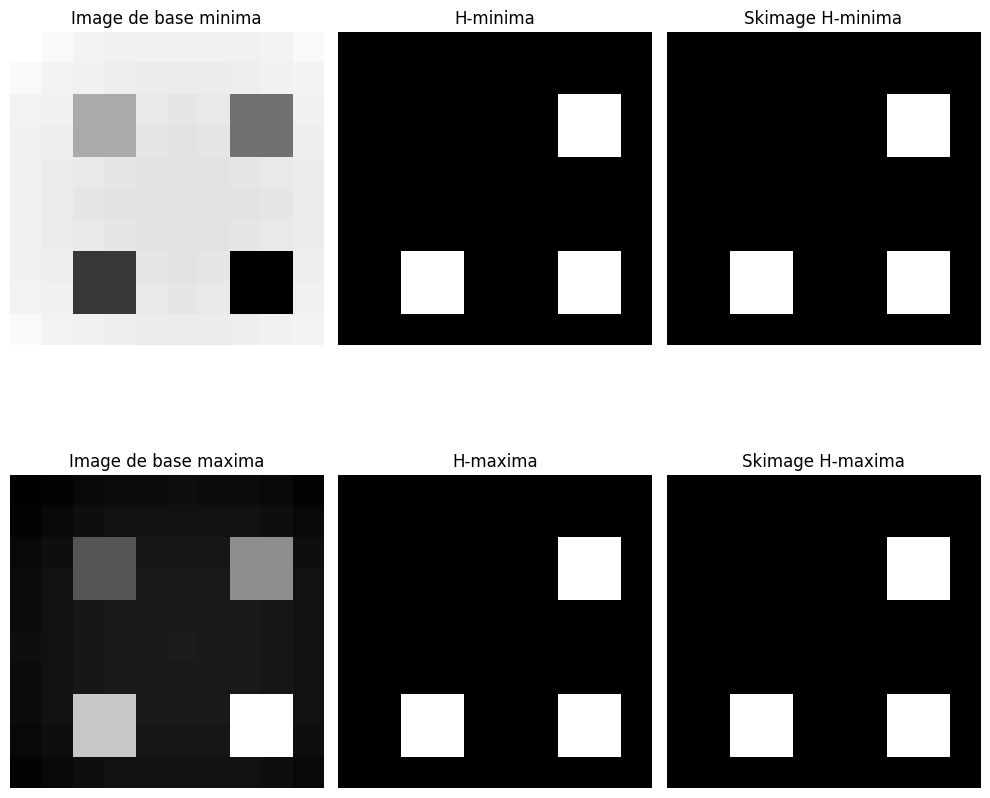

In [66]:
w = 10
x, y = np.mgrid[0:w,0:w]

f = 180 + 0.2*((x - w/2)**2 + (y-w/2)**2)
f[2:4,2:4] = 160; f[2:4,7:9] = 140; f[7:9,2:4] = 120; f[7:9,7:9] = 100
f = f.astype(int)
minima = skimage.morphology.extrema.h_minima(f, 40)
my_minima = hminima(f, 40)

g = 20 - 0.2*((x - w/2)**2 + (y-w/2)**2)
g[2:4,2:4] = 40; g[2:4,7:9] = 60; g[7:9,2:4] = 80; g[7:9,7:9] = 100
g = g.astype(int)
maxima = skimage.morphology.extrema.h_maxima(g, 40)
my_maxima = hmaxima(g, 40)
fig,ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0][0].imshow(f, cmap='gray')
ax[0][0].set_title('Image de base minima')
ax[0][1].imshow(my_minima, cmap='gray')
ax[0][1].set_title('H-minima')
ax[0][2].imshow(minima, cmap='gray')
ax[0][2].set_title('Skimage H-minima')
ax[1][0].imshow(g, cmap='gray')
ax[1][0].set_title('Image de base maxima')
ax[1][1].imshow(my_maxima, cmap='gray')
ax[1][1].set_title('H-maxima')
ax[1][2].imshow(maxima, cmap='gray')
ax[1][2].set_title('Skimage H-maxima')
for cell in np.ndindex(ax.shape):
    ax[cell].axis('off')
fig.tight_layout()
plt.show()

## Applications 

### 1. Seuillage par hystérèse

Bien souvent, un seuillage global d’une image ne permet pas de segmenter efficacement des objets. Le principe du seuillage par hystérese est le suivant :

- on utilise un seuil large pour conserver le maximum de points des objets à segmenter (image $`f_1`$).
- on utilise un seuil étroit pour conserver uniquement des points appartenant aux objets à segmenter (image $`f_2`$).
on reconstruit les objets à segmenter en effectuant une reconstruction géodésique par dilatation de l’image du seuil étroit dans l’image du seuil large.
Voir également : http://dpt-info.u-strasbg.fr/~cronse/TIDOC/FEAT/double.html

Ainsi dans le résultat final apparaîtront uniquement les composantes connexes de `f_1` contenant les points de `f_2`. Cette technique ne fonctionne que si, dans $`f_1`$, il n’existe aucune connexion entre les objets à segmenter et les objets indésirables (bruit, fond de l’image...). 
Illustrez l’intérêt de cette technique sur l’image ci-dessous et écrire le code correspondant.

<img src="pcb_gray.png" width="400">

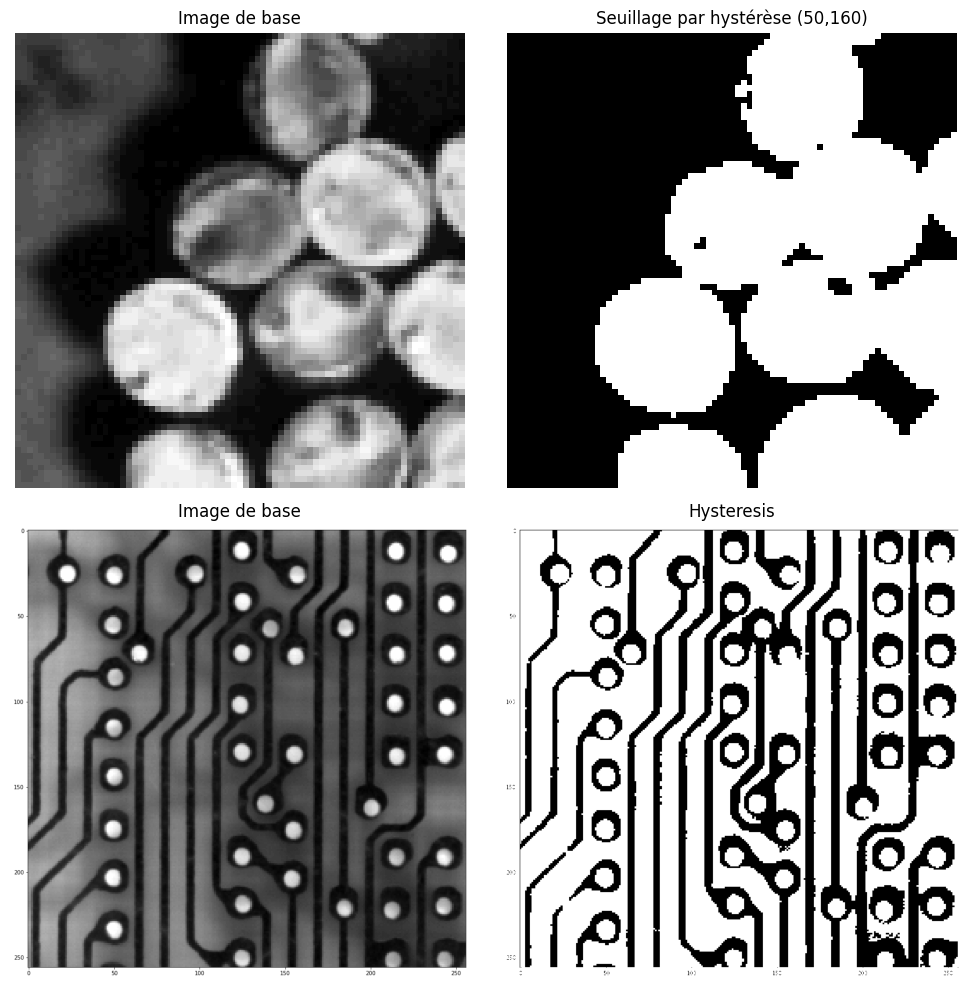

In [80]:
# Sur l'image ci-dessus, le seuillage par hystérèse permet de ne garder que les circuits de la carte PCB
def hysterese(img,seuil1,seuil2):
    f1 = img.copy()
    f1[img < seuil1] = 0
    f1[img >= seuil1] = 255
    f2 = img.copy()
    f2[img < seuil2] = 0
    f2[img >= seuil2] = 255
    return skimage.morphology.reconstruction(f2,f1)

img = skimage.io.imread('bois.png', as_gray=True)
img = skimage.img_as_ubyte(img)
fig,ax = plt.subplots(2,2, figsize=(10, 10))
ax[0][0].imshow(img, cmap='gray')
ax[0][0].set_title('Image de base')
ax[0][1].imshow(hysterese(img,50,160), cmap='gray')
ax[0][1].set_title('Seuillage par hystérèse (50,160)')
img = skimage.io.imread('pcb_gray.png', as_gray=True)
img = skimage.img_as_ubyte(img)
ax[1][0].imshow(img, cmap='gray')
ax[1][0].set_title('Image de base')
ax[1][1].imshow(hysterese(img,50,160), cmap='gray')
ax[1][1].set_title('Hysteresis')
for cell in np.ndindex(ax.shape):
    ax[cell].axis('off')
fig.tight_layout()
plt.show()


### 2. Ouverture par reconstruction

Une ouverture par reconstruction est définie par la composition d'un opérateur anti-extensif et d'une reconstruction géodésique par dilatation.
On considérera l'ouverture par reconstruction qui s'appuie sur une érosion morphologique suivie d'une reconstruction géodésique. Plus précisément, l'ouverture par reconstruction est définie par :
$$`\gamma^R_B(f)=R_f[\varepsilon_B(f)]` $$

Implémenter l'opérateur d'ouverture par reconstruction et illustrer son intérêt dans le cadre de la simplification d'images.

In [ ]:
def ouverture_reconstruct(img, radius):
    footprint = skimage.morphology.disk(radius)
    return skimage.morphology.reconstruction(skimage.morphology.erosion(img, footprint), img)